In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

In [3]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else device)
print(device)

cuda


In [4]:
def image_show(img, grid = None):
    img_arr = img.permute(1, 2, 0).numpy()
    w = 1 if grid == None else grid
    plt.figure(figsize=(w, w), frameon=False)
    plt.axes([0, 0, 1, w])
    plt.imshow(img_arr, cmap='gray')
    plt.axis(False)
    plt.show()

In [5]:
class MorphologicalSmoothing:
    def __init__(self, debug = False):
        
        self.debug = debug

    def __call__(self, img):

        img_np = np.array(img.convert('L'))
        self.debug_image(img_np)

        inverted = cv2.bitwise_not(img_np)
        self.debug_image(inverted)  

        _, thresh = cv2.threshold(inverted, 10, 255, cv2.THRESH_BINARY)
        coords = cv2.findNonZero(thresh)
        x, y, w, h = cv2.boundingRect(coords)  # Get bounding box
        cropped = inverted[y:y+h, x:x+w]

        padding = 6
        padded = cv2.copyMakeBorder(
            cropped, padding, padding, padding, padding,
            cv2.BORDER_CONSTANT, value=0
        )
        resized = cv2.resize(padded, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_LINEAR)
        self.debug_image(resized)  

        kernel = np.ones((2, 2), np.uint8)
        # eroded = cv2.erode(inverted, kernel, iterations=2)
        dilated = cv2.dilate(resized, kernel, iterations=2)
        self.debug_image(dilated)
        opened = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel)
        self.debug_image(opened)
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
        self.debug_image(closed)

        blurred = cv2.GaussianBlur(closed, (7, 7), 0)
        self.debug_image(blurred)
        # _, smoothed = cv2.threshold(blurred, 80, 200, cv2.THRESH_BINARY)

        resized = cv2.resize(blurred, (64, 64))
        return Image.fromarray(resized)
    
    def debug_image(self, img):
        
        if self.debug:
            tensored = transforms.ToTensor()(cv2.resize(img, (64, 64)))
            normalized = transforms.Normalize((0.5), (0.5))(tensored)
            image_show(normalized, 3)

In [6]:
def get_rotated_transform(angle):
    return transforms.Compose([
        MorphologicalSmoothing(False),
        transforms.Lambda(lambda img: torchvision.transforms.functional.rotate(img, angle)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [7]:
train_dir = 'data/images/train'
test_dir = 'data/images/test'
rotation_angles = [-15, -10, -5, 0, 5, 10, 15]

transform = transforms.Compose([MorphologicalSmoothing(False), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
rotated_datasets = [datasets.ImageFolder(train_dir, transform=get_rotated_transform(a)) for a in rotation_angles]
augmented_dataset = ConcatDataset(rotated_datasets)

set_size = int(round(0.8 * len(augmented_dataset)))
trainset, valset = torch.utils.data.random_split(augmented_dataset, [set_size, len(augmented_dataset) - set_size], generator=torch.Generator().manual_seed(91))
testset = datasets.ImageFolder(test_dir, transform)
training_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [8]:
df = pd.read_csv('data/TamilChar.csv', header=0)
char_list = [''.join(chr(int(f"0x{code}", 16)) for code in element.split(' ')) for element in df["Unicode"]]

print(char_list)
print(len(char_list))

classes = []
for i in range(156):
    index = int(testset.classes[i])
    char = char_list[index]
    classes.append(char)

print(classes)

['அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'ஃ', 'க', 'ங', 'ச', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ப', 'ம', 'ய', 'ர', 'ல', 'வ', 'ழ', 'ள', 'ற', 'ன', 'ஸ', 'ஷ', 'ஜ', 'ஹ', 'க்ஷ', 'கி', 'ஙி', 'சி', 'ஞி', 'டி', 'ணி', 'தி', 'நி', 'பி', 'மி', 'யி', 'ரி', 'லி', 'வி', 'ழி', 'ளி', 'றி', 'னி', 'ஸி', 'ஷி', 'ஜி', 'ஹி', 'க்ஷி', 'கீ', 'ஙீ', 'சீ', 'ஞீ', 'டீ', 'ணீ', 'தீ', 'நீ', 'பீ', 'மீ', 'யீ', 'ரீ', 'லீ', 'வீ', 'ழீ', 'ளீ', 'றீ', 'னீ', 'ஸீ', 'ஷீ', 'ஜீ', 'ஹீ', 'க்ஷீ', 'கு', 'ஙு', 'சு', 'ஞு', 'டு', 'ணு', 'து', 'நு', 'பு', 'மு', 'யு', 'ரு', 'லு', 'வு', 'ழு', 'ளு', 'று', 'னு', 'கூ', 'ஙூ', 'சூ', 'ஞூ', 'டூ', 'ணூ', 'தூ', 'நூ', 'பூ', 'மூ', 'யூ', 'ரூ', 'லூ', 'வூ', 'ழூ', 'ளூ', 'றூ', 'னூ', 'ா', 'ெ', 'ே', 'ை', 'ஸ்ரீ', 'ஸு', 'ஷு', 'ஜு', 'ஹு', 'க்ஷு', 'ஸூ', 'ஷூ', 'ஜூ', 'ஹூ', 'க்ஷூ', 'க்', 'ங்', 'ச்', 'ஞ்', 'ட்', 'ண்', 'த்', 'ந்', 'ப்', 'ம்', 'ய்', 'ர்', 'ல்', 'வ்', 'ழ்', 'ள்', 'ற்', 'ன்', 'ஸ்', 'ஷ்', 'ஜ்', 'ஹ்', 'க்ஷ்', 'ஔ']
156
['அ', 'ஆ', 'ஓ', 'ஙூ', 'சூ', 'ஞூ', 'டூ', 'ணூ', 'தூ', 'நூ', 'பூ', 'மூ', 'யூ', 'ஃ', 'ரூ'

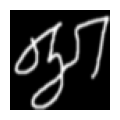

5
torch.Size([1, 64, 64])


In [9]:
feature, label = trainset.__getitem__(1)
image_show(feature)
print(label)
print(feature.shape)

In [10]:
class DeepTamil2(nn.Module):
    def __init__(self):
        super(DeepTamil2, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 156)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.bn1(self.conv2(x))))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.bn2(self.conv4(x))))

        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.bn3(self.conv6(x))))

        x = F.relu(self.conv7(x))
        x = self.pool(F.relu(self.bn4(self.conv8(x))))

        x = x.view(-1, 128 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
model = DeepTamil2()
model.to(device)

DeepTamil2(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): Batc

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=0.0001, lr=1e-4)

In [11]:
def save_model(model, name):
    torch.save(model.state_dict(), f'{name}.pt')

In [20]:
def early_stop(values):
    if len(values) < 4:
        return True  # Not enough data to compare

    last = round(values[-1], 4)
    second_last = round(values[-2], 4)
    
    return last > second_last

In [21]:
epoch_list = []
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

mini_batch_list = []
running_losses = []
epochs = 45

for epoch in range(epochs):
    epoch_list.append(epoch)

    curr_train_loss = 0.0
    train_total = 0
    train_correct = 0
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        curr_batch_size = labels.size(0)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_train_loss += loss.item()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_losses.append(running_loss)
            mini_batch_list.append(epoch + i * curr_batch_size / len(trainset))
            running_loss = 0.0
    
    train_loss.append(curr_train_loss / len(trainset) * curr_batch_size)
    train_accuracy.append(train_correct / train_total)
    
    val_correct = 0
    val_total = 0
    curr_val_loss = 0.0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            curr_val_loss += criterion(outputs, labels).item()
    val_loss.append(curr_val_loss / len(valset) * curr_batch_size)
    val_accuracy.append(val_correct / val_total)
    
    save_model(model, f'tamil_model_{epoch}')

    print('EPOCH ' + str(epoch + 1))
    print('Training loss: ' + str(train_loss[-1]))
    print('Training accuracy: ' + str(train_accuracy[-1]))
    print('Validation loss: ' + str(val_loss[-1]))
    print('Validation accuracy: ' + str(val_accuracy[-1]))
    print('----------------------------------------------------')

    if not early_stop(val_accuracy):
        break

[1,   100] loss: 0.103
[1,   200] loss: 0.083
[1,   300] loss: 0.077
[1,   400] loss: 0.068
[1,   500] loss: 0.069
[1,   600] loss: 0.062
[1,   700] loss: 0.064
[1,   800] loss: 0.072
[1,   900] loss: 0.065
[1,  1000] loss: 0.074
[1,  1100] loss: 0.056
[1,  1200] loss: 0.056
[1,  1300] loss: 0.059
[1,  1400] loss: 0.062
[1,  1500] loss: 0.060
[1,  1600] loss: 0.059
[1,  1700] loss: 0.054
[1,  1800] loss: 0.052
[1,  1900] loss: 0.054
[1,  2000] loss: 0.056
[1,  2100] loss: 0.060
[1,  2200] loss: 0.057
EPOCH 1
Training loss: 0.024715548123927105
Training accuracy: 0.9770280983000088
Validation loss: 0.025451287241151012
Validation accuracy: 0.9755482270702971
----------------------------------------------------
[2,   100] loss: 0.038
[2,   200] loss: 0.041
[2,   300] loss: 0.041
[2,   400] loss: 0.043
[2,   500] loss: 0.039
[2,   600] loss: 0.039
[2,   700] loss: 0.038
[2,   800] loss: 0.040
[2,   900] loss: 0.038
[2,  1000] loss: 0.044
[2,  1100] loss: 0.040
[2,  1200] loss: 0.045
[2,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


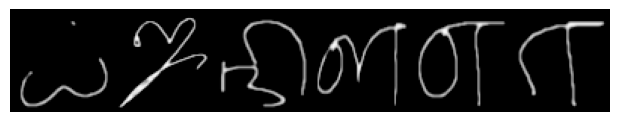

torch.Size([128, 1, 64, 64])
output tensor([ 49,  82,  93,  76, 112,  21], device='cuda:0') ['ய்', 'ஜ', 'நி', 'ள', 'எ', 'ா']
label tensor([ 49,  82,  93,  76, 112,  21]) ['ய்', 'ஜ', 'நி', 'ள', 'எ', 'ா']


In [22]:
with torch.no_grad():
    feature, label = test_loader._get_iterator().__next__()
    image_show(torchvision.utils.make_grid(feature[:6]), 6)
    print(feature.shape)
    out = model(feature.to(device))
    _, predicted = torch.max(out.data, 1)
    print('output', predicted[:6], [classes[p] for p in predicted[:6]])
    print('label', label[:6], [classes[p] for p in label[:6]])

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91.851742 %
